In [1]:
using PyPlot, Printf, DelimitedFiles, Statistics
using CuArrays;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/Pcs5V/src/Revise.jl:1217
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


In [2]:
KBT = KB_kcalpermol*300.0;
K = 16;
spring_constant = 50.0;

In [3]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/string_alad/10_crd_convert/umb.%d.dat" k
  x = readdlm(filename);
  push!(data_k, x)
end

filename = @sprintf "data/string_alad/10_crd_convert/umb_center.dat"
x = readdlm(filename);
umbrella_center =  x;

In [4]:
#gpu_data_k = CuArray.(data_k);
#gpu_umbrella_center = CuArray(umbrella_center);

# delta pmf between the umbrella snapshots and the 1st snapshot

In [5]:
@time delta_pmf = sp_delta_pmf(umbrella_center, data_k, KBT, spring_constant);

  3.048170 seconds (10.78 M allocations: 571.283 MiB, 5.89% gc time)


# design matrix for linear regression

delta_pmf = M * weight

In [6]:
umbrella_center

16×39 Array{Float64,2}:
 2.3031  3.0101  1.0327   3.6959  3.4973  0.642    …  4.9414  5.5615  1.2193   4.9167  7.6969  1.0717
 2.3763  2.8039  0.91678  3.6872  3.4458  0.67865     4.7858  5.6474  1.2095   5.076   7.7222  0.94475
 2.4226  2.7955  0.97764  3.7438  3.401   0.69919     4.5195  5.7144  1.1128   5.0075  7.7528  0.87883
 2.4546  2.7813  1.0127   3.793   3.3321  0.70692     4.2708  5.8112  0.96118  4.9686  7.7956  0.81796
 2.484   2.7799  1.067    3.8314  3.2764  0.70999     4.0425  5.9302  0.76461  4.9482  7.8348  0.74481
 2.5364  2.7454  1.1046   3.8563  3.2977  0.7302   …  3.8701  6.0348  0.53607  4.961   7.8255  0.7512
 2.5657  2.7298  1.1278   3.8603  3.3418  0.75361     3.7742  6.1459  0.33109  4.9946  7.801   0.79519
 2.5864  2.6471  1.0979   3.8408  3.3588  0.76618     3.7521  6.3064  0.12246  5.071   7.7897  0.83066
 2.6738  2.4752  1.0431   3.7932  3.4052  0.77455     3.8005  6.3324  0.19133  5.1897  7.755   0.9082
 2.719   2.4038  1.0296   3.7386  3.4437  0.77459   

In [7]:
sigma_rdf = 2.0;
@time M = sp_design_matrix(umbrella_center, data_k, sigma_rdf);

  0.582023 seconds (1.46 M allocations: 150.932 MiB, 9.79% gc time)


# lasso

Solve weights for 

delta_pmf = M * weight

In [8]:
M_standardized, mean_M, std_M = sp_standardize(M);
delta_pmf_vector = delta_pmf[:] .- mean(delta_pmf);

In [9]:
lambda = 1.0;
@time weight = sp_admm(delta_pmf_vector, M_standardized, lambda);

[ Cycle Count = 102 ]
[ Complete Condition ]
  Max Differ = 9.543670998368725e-6


  0.924240 seconds (4.07 M allocations: 195.739 MiB, 6.73% gc time)


In [44]:
lambda = 0.001;
@time weight = sp_descent2(delta_pmf_vector, M_standardized, lambda);

[ Cycle Count = 10001 ]
[ Complete Condition ]
  Max Differ = 0.0001381869703154237


  0.022455 seconds (330.19 k allocations: 65.468 MiB)


In [45]:
weight

16-element Array{Float64,1}:
  0.7582296987705447
 -4.2077886786155805
  5.218114509093195
 -2.6068809806847124
 -0.0
  0.0
  0.6434527008029209
 -0.0
 -1.555553016092653
  0.9068375176201493
  0.0
 -2.201220208029573
  6.960467906282841
 -7.177343963268258
  3.5312755048029434
 -1.0395665066811326

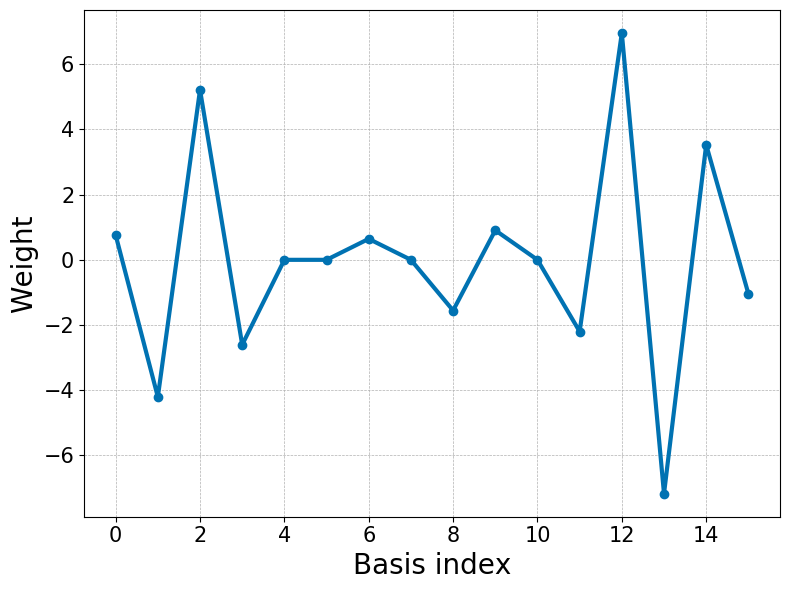

In [49]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(weight[:], linewidth=3, "-o")
xlabel("Basis index",fontsize=20)
ylabel("Weight",fontsize=20)

#ax.set(xlim=[-1, 60], ylim=[-0.3, 0.3])
ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_weight.png", dpi=350)

# cumulate PMF

In [50]:
pmf = sp_cumulate_pmf(umbrella_center, weight, umbrella_center, sigma_rdf, mean_M, std_M)

16-element Array{Float64,1}:
  1.2131347959366714
  0.0
  3.5021641805042805
  6.358393382744772
  8.98591637783419
 10.957564077213725
 12.507534147683753
 13.536732684893718
 14.540230486591923
 16.250512926599473
 16.8364297544995
 15.830229550337144
 12.7519907199718
  9.226105837476133
  7.103766293006821
  5.985314601807772

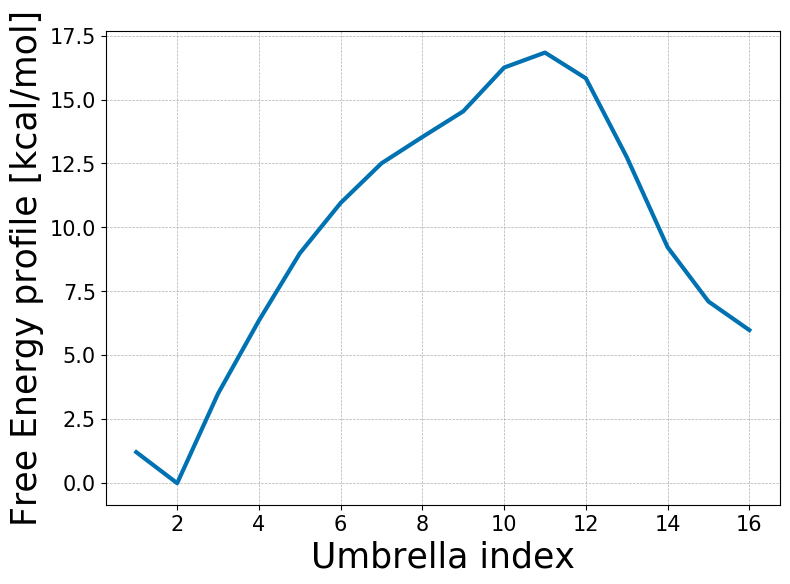

In [51]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(1:K, pmf, linewidth=3)
xlabel("Umbrella index",fontsize=25)
ylabel("Free Energy profile [kcal/mol]",fontsize=25)

ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_pmf..png", dpi=350)